# Imports and helper functions

In [48]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np
from scipy.stats import norm
from pandas import Series, read_csv, DataFrame
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima


TRAINING_PERCENTAGE = 0.8
INPUT = 'input'
OUTPUT = 'output'
TRAINING = 'training'
TESTING = 'testing'


def adfuller_test(series: Series):
    result = adfuller(series, autolag='AIC')
    adfstat = result[0]
    pvalue = result[1]
    print("-"*30)
    print(f'ADF Statistic: {adfstat}')
    print(f'p-value: {pvalue}')

    critvals_lt_adfstat = 0
    print('Critial Values:')
    for key, value in result[4].items():
        print(f'{key}, {value}')
        if (value < adfstat):
            critvals_lt_adfstat += 1
    print("-"*30)
    print(f"Critical values less than adf statistic: {critvals_lt_adfstat}")
    print(f"p-value is below the 5% significance level: {pvalue < 0.05}")
    print(f"Stationary? {critvals_lt_adfstat == 0 and pvalue < 0.05}")
    print("-"*30)
    print("")


# check if series is randomly distributed
def israndom(data: Series, corr_limit: float) -> bool:
    output = sm.stats.acorr_ljungbox(data)
    return not (output['lb_pvalue'] < corr_limit).any()


def zscore(series: Series) -> Series:
    return Series((series - series.mean()) / series.std())


# convert series to supervised learning set with inputs and outputs
def reshapedata(data: np.array, n_in: int, n_out: int) -> dict[np.array]:
    inarr = [np.array(data[i:i+n_in]) for i in range(len(data)-n_in-n_out+1)]
    outarr = [np.array(data[i:i+n_out]) for i in range(n_in, len(data)-n_out+1)]
    return {
        INPUT: np.array(inarr), 
        OUTPUT: np.array(outarr)
    }


# create function to split data into train and test sets
def splitdata(data: np.array, trainpercentage: float) -> tuple[np.array, np.array]:
    idx = int(len(data) * trainpercentage)
    return {
        TRAINING: data[0:idx], 
        TESTING: data[idx:len(data)]
    }


def predictdata(indata: Series, model: Sequential, n_in: int, n_out: int) -> tuple[np.array, np.array]:
    data = np.array(indata.values.tolist())
    splitteddata = splitdata(data, TRAINING_PERCENTAGE)
    training_data = reshapedata(splitteddata[TRAINING], n_in, n_out)
    testing_data = reshapedata(splitteddata[TESTING], n_in, n_out)

    hist = model.fit(training_data[INPUT], training_data[OUTPUT], epochs=10, verbose=0)
    # plt.plot(hist.history['loss'], label='train')
    # plt.show()
    predictions = model.predict(testing_data[INPUT], verbose=0)
    
    return predictions, testing_data[OUTPUT]


def find_and_plot_anomalies(exp: np.ndarray, pred: np.ndarray, title: str) -> None:
    pred_error_series = Series(np.abs(exp - pred), index=exp.index)
    sorted = pred_error_series.sort_values(ascending=False)
    anomalies = sorted[:int(0.005*len(sorted))]

    exp.plot(kind='line', title=title, xlabel='Time', ylabel='mV', style='g-')
    pred.plot(kind='line', title=title, style='r--')
    for a in anomalies.index:
        plt.plot(a, exp[a], 'bo', markersize=5)
    plt.title(f'{title}\nAnomalies found are displayed as blue dots\nExpected in green, predicted in red')
    plt.show()


def find_and_plot_anomalies_2d(exp: np.ndarray, pred: np.ndarray, title: str) -> None:
    df = DataFrame(np.abs(exp - pred))
    pred_error_series = Series(
        [np.asarray(x) for x in df[[df.columns[0], df.columns[1]]].values]
    )

    sum_per_index = pred_error_series.apply(lambda x: x[0] + x[1])
    sorted = pred_error_series.loc[sum_per_index.sort_values(ascending=False).index]
    anomalies = sorted[:int(0.005*len(sorted))]

    # plot first column of exp


    plt.plot(exp, 'g-')
    plt.plot(pred, 'r--')
    plt.xlabel('Time')
    plt.ylabel('mV')
    for a in anomalies.index:
        plt.plot(a, exp[a][0], 'bo', markersize=5)
        plt.plot(a, exp[a][1], 'bo', markersize=5)
    plt.title(f'{title}\nAnomalies found are displayed as blue dots\nExpected in green, predicted in red')
    plt.show()

# Task 3.1 - Anomaly detection for uni-variate series with ARIMA

### Read and parse the data

In [51]:
data = read_csv('TemperatureAnomalies.csv', parse_dates=True)
series = Series(data['temperature change'].values, index=data['year'].values)

### Plot the data in various ways

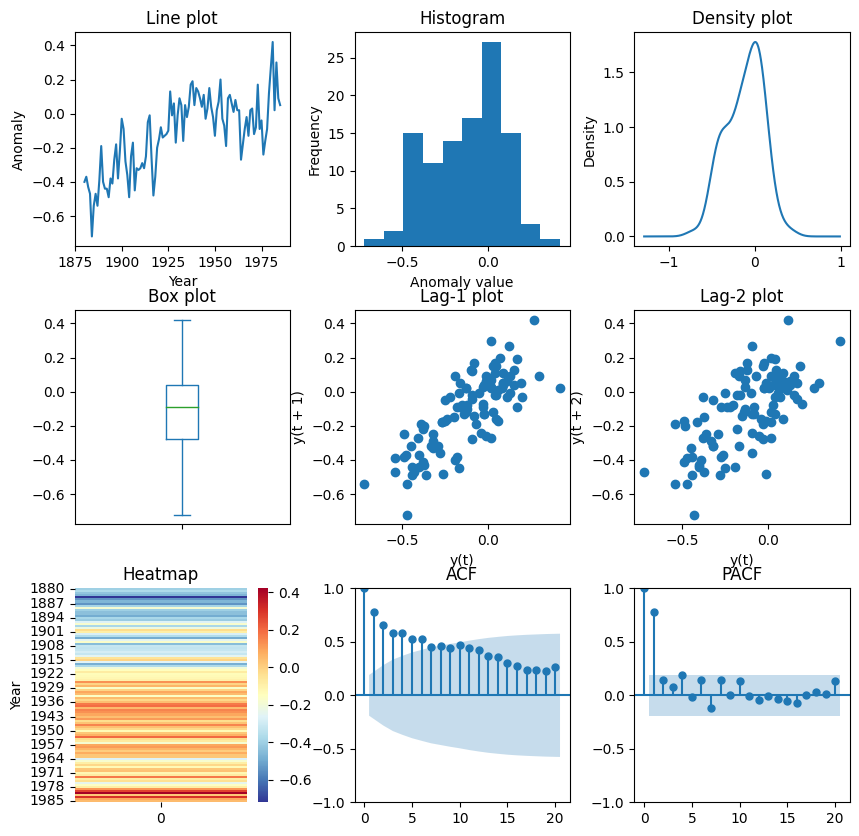

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

series.plot(ax=axes[0, 0], kind='line', title='Line plot', xlabel='Year', ylabel='Anomaly')
series.plot(ax=axes[0, 1], kind='hist', title='Histogram', xlabel='Anomaly value', ylabel='Frequency')
series.plot(ax=axes[0, 2], kind='density', title='Density plot', xlabel='??', ylabel='Density')
series.plot(ax=axes[1, 0], kind='box', title='Box plot')
lag_plot(series, ax=axes[1, 1], lag=1)
axes[1, 1].set_title('Lag-1 plot')
lag_plot(series, ax=axes[1, 2], lag=2)
axes[1, 2].set_title('Lag-2 plot')
plot_acf(series.values.reshape(-1, 1), ax=axes[2, 1], lags=20, title='ACF')
plot_pacf(series, ax=axes[2, 2], lags=20, title='PACF')
heatmap(DataFrame(series), cmap='RdYlBu_r', ax=axes[2, 0])
axes[2, 0].set_title('Heatmap')
axes[2, 0].set_ylabel('Year')
axes[2, 0].set_xlabel('')

fig.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

### Constructing the ARIMA model

 ARIMA(1,1,4)(0,0,0)[0] intercept


/Users/ludvigsmacbook/Documents/TEBSM 120HP/Årskurs 1/IL2233 Embedded- Intelligence/project/source/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ludvigsmacbook/Documents/TEBSM 120HP/Årskurs 1/IL2233 Embedded- Intelligence/project/source/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ludvigsmacbook/Documents/TEBSM 120HP/Årskurs 1/IL2233 Embedded- Intelligence/project/source/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ludvigsmacbook/Documents/TEBSM 120HP/Årskurs 1/IL2233 Embedded- Intelligence/project/source/.venv/lib

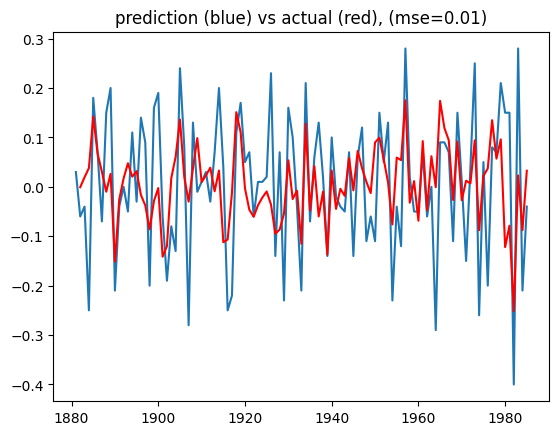

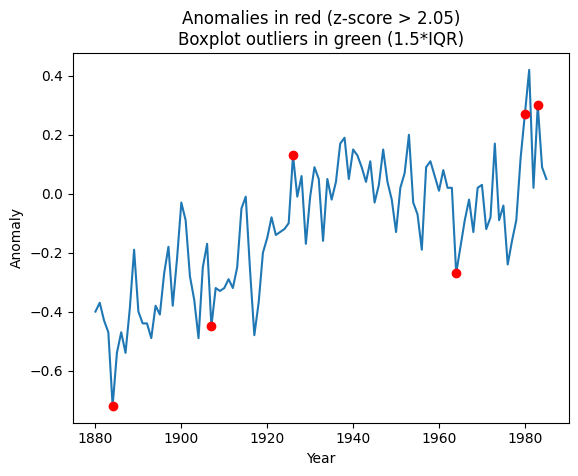

In [52]:
# adfuller_test(series)
series_fod = series.diff().dropna()
# adfuller_test(series_fod)
# series_fod.plot(kind='line', title='Line plot', xlabel='Year', ylabel='Anomaly')

ANOMALY_RATIO = 0.02

print(auto_arima(series_fod, start_p=0, max_p=6, d=1, start_q=2, max_q=10, seasonal=False, information_criterion='aic'))
p = 1
d = 0
q = 4
model = ARIMA(series_fod, order=(p, d, q)).fit()

pred = model.predict()
pred = Series(pred, index=series_fod.index)
mse = mean_squared_error(series_fod, pred)

plt.plot(series_fod, label='Actual')
plt.plot(pred[1:], color='red', label='Predicted')
plt.title(f'prediction (blue) vs actual (red), (mse={mse:.2f})')
plt.show()

pred_error_series = Series(np.abs(series_fod - pred), index=series_fod.index)
pred_is_random = f'{"" if israndom(pred_error_series, 0.05) else "not "}random'

zscores = zscore(pred_error_series)
anomaly_zscore_lim = norm.ppf(1 - ANOMALY_RATIO)
anomalies = zscores[zscores > anomaly_zscore_lim]

# find the first quartile and third quartile
q1 = pred_error_series.quantile(0.25)
q3 = pred_error_series.quantile(0.75)
# find the interquartile range
iqr = q3 - q1
# find the outlier step
outlier_step = 1.5 * iqr
# find the outliers
outliers = pred_error_series[
    (pred_error_series <= q1 - outlier_step) | 
    (pred_error_series >= q3 + outlier_step)]

series.plot(kind='line', title='Line plot', xlabel='Year', ylabel='Anomaly')
for a in anomalies.index:
    plt.plot(a, series[a], 'ro')
for o in outliers.index:
    plt.plot(o, series[o], 'go')
plt.title(f'Anomalies in red (z-score > {anomaly_zscore_lim:.2f})\nBoxplot outliers in green (1.5*IQR)')
plt.show()

# Task 3.2 - Anomaly detection with LSTM in ECG signals

### Read and parse the data

In [3]:
data = read_csv('ecg.csv', skiprows=[1], index_col=["'Elapsed time'"])

### Exploratory data analysis

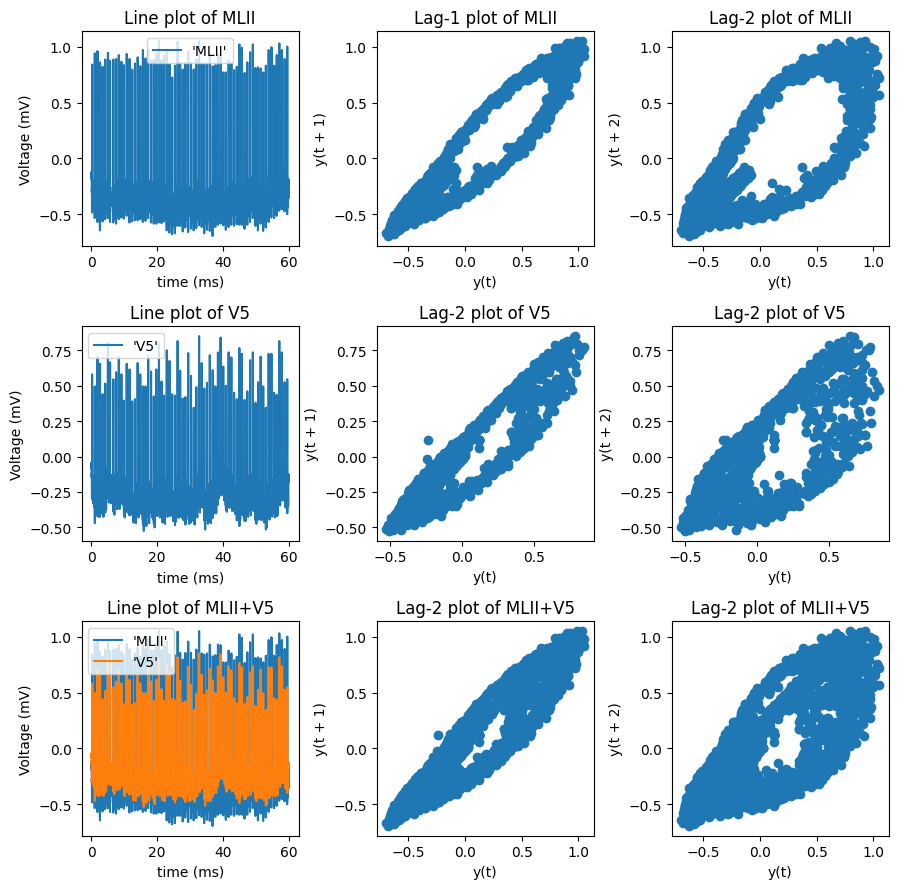

In [77]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

data.plot(ax=axes[0, 0], y=data.columns[0], title='Line plot of MLII', xlabel='time (ms)', ylabel='Voltage (mV)')
lag_plot(data[data.columns[0]], ax=axes[0, 1], lag=1)
axes[0, 1].set_title('Lag-1 plot of MLII')
lag_plot(data[data.columns[0]], ax=axes[0, 2], lag=2)
axes[0, 2].set_title('Lag-2 plot of MLII')

data.plot(ax=axes[1, 0], y=data.columns[1], title='Line plot of V5', xlabel='time (ms)', ylabel='Voltage (mV)')
lag_plot(data[data.columns[1]], ax=axes[1, 1], lag=1)
axes[1, 1].set_title('Lag-2 plot of V5')
lag_plot(data[data.columns[1]], ax=axes[1, 2], lag=2)
axes[1, 2].set_title('Lag-2 plot of V5')

data.plot(ax=axes[2, 0], y=data.columns[:], title='Line plot of MLII+V5', xlabel='time (ms)', ylabel='Voltage (mV)')
lag_plot(data, ax=axes[2, 1], lag=1)
axes[2, 1].set_title('Lag-2 plot of MLII+V5')
lag_plot(data, ax=axes[2, 2], lag=2)
axes[2, 2].set_title('Lag-2 plot of MLII+V5')

plt.subplots_adjust(wspace=1.2, hspace=1.2)
plt.tight_layout()
plt.show()

### Model Construction and evaluation, treat the columns as uni-variate series

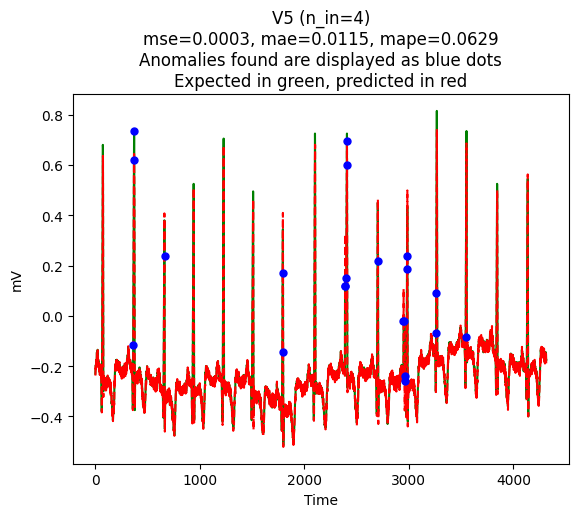


1 results
name  n_in      mse     mae    mape
  V5     4 0.000328 0.01154 0.06287


In [118]:

N_IN = [4, 8, 16]
N_OUT = 1

datasets = [
    Series(data[data.columns[1]].values, index=data.index, name='V5'),
    Series(data[data.columns[0]].values, index=data.index, name='MLII')
]

models = [
    Sequential([
        LSTM(100, activation='relu', input_shape=(n, 1)),
        Dense(1)
    ]) for n in N_IN
]
for m in models:
    m.compile(optimizer='adam', loss='mse')

results = DataFrame(columns=['name', 'n_in', 'mse', 'mae', 'mape'])
for dataset in datasets:
    for i, model in enumerate(models):
        prediction, expected = predictdata(dataset, model, N_IN[i], N_OUT)
        mse = mean_squared_error(expected, prediction)
        mae = mean_absolute_error(expected, prediction)
        mape = mean_absolute_percentage_error(expected, prediction)
        results.loc[len(results)] = [dataset.name, N_IN[i], mse, mae, mape]
        title = f'{dataset.name} (n_in={N_IN[i]})\nmse={mse:.4f}, mae={mae:.4f}, mape={mape:.4f}'
        find_and_plot_anomalies(Series(expected.reshape(-1)), Series(prediction.reshape(-1)), title)
        break
    break
        

print(f'\n{len(results)} results')
print(results.to_string(index=False))


### Model Construction and evaluation, treat the columns as one bi-variate series

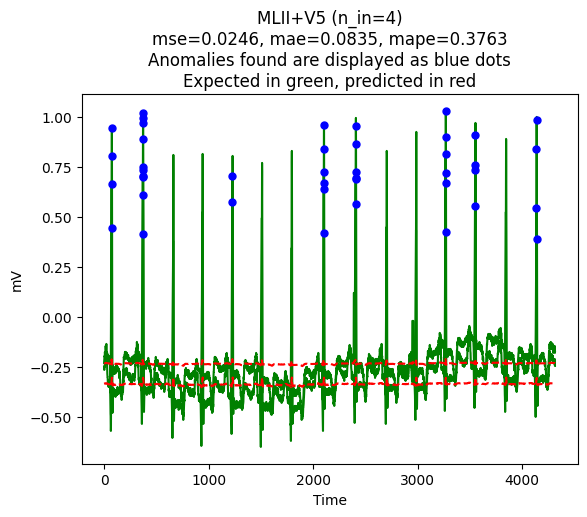

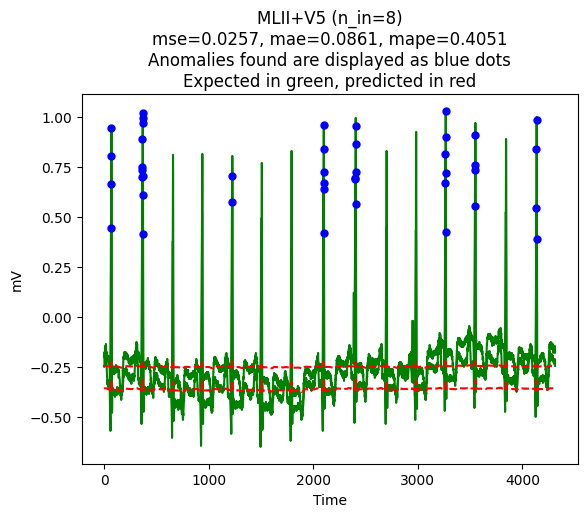

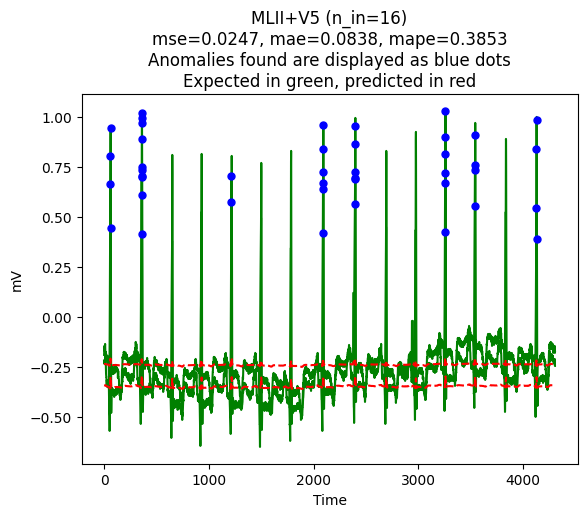


3 results
   name  n_in      mse      mae     mape
MLII+V5     4 0.024589 0.083544 0.376320
MLII+V5     8 0.025709 0.086122 0.405114
MLII+V5    16 0.024749 0.083807 0.385325


In [50]:
N_IN = [4, 8, 16]
N_OUT = 1

dataset = Series(
    [np.asarray(x, dtype='float') for x in data[[data.columns[0], data.columns[1]]].values],
    index=data.index,
    name='MLII+V5'
)

models = [
    Sequential([
        LSTM(100, activation='relu', input_shape=(n, 2)),
        Dense(2)
    ]) for n in N_IN
]
for m in models:
    m.compile(optimizer='adam', loss='mse')

results = DataFrame(columns=['name', 'n_in', 'mse', 'mae', 'mape'])
for i, model in enumerate(models):
    prediction, expected = predictdata(dataset, model, N_IN[i], N_OUT)
    expected = expected.reshape(-1, 2) # removes unnecesary dimension
    mse = mean_squared_error(expected, prediction)
    mae = mean_absolute_error(expected, prediction)
    mape = mean_absolute_percentage_error(expected, prediction)
    results.loc[len(results)] = [dataset.name, N_IN[i], mse, mae, mape]
    title = f'{dataset.name} (n_in={N_IN[i]})\nmse={mse:.4f}, mae={mae:.4f}, mape={mape:.4f}'
    find_and_plot_anomalies_2d(expected, prediction, title)
        

print(f'\n{len(results)} results')
print(results.to_string(index=False))